In [1]:
import pandas as pd

# Load the dataset
file_path = 'C:/Users/amit_/Downloads/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition/ObesityDataSet_raw_and_data_sinthetic.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score
import numpy as np

# Dropping target variable for clustering purposes
data_features = data.drop(columns=['NObeyesdad'])

# Encoding categorical features
categorical_columns = data_features.select_dtypes(include=['object']).columns
data_encoded = data_features.copy()

# Using LabelEncoder for simplicity
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col, le in label_encoders.items():
    data_encoded[col] = le.fit_transform(data_encoded[col])

# Normalizing the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_encoded)

# Perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=7)  # Assuming 7 clusters based on NObeyesdad unique values
cluster_labels = clustering.fit_predict(data_normalized)

# Converting target variable to numerical for accuracy calculation
label_encoder_target = LabelEncoder()
true_labels = label_encoder_target.fit_transform(data['NObeyesdad'])

# Calculate accuracy
accuracy = accuracy_score(true_labels, cluster_labels)

# Mapping back the clusters to their respective labels for better understanding
cluster_to_label = {i: label_encoder_target.classes_[i] for i in range(7)}

accuracy, cluster_to_label

(0.167693036475604,
 {0: 'Insufficient_Weight',
  1: 'Normal_Weight',
  2: 'Obesity_Type_I',
  3: 'Obesity_Type_II',
  4: 'Obesity_Type_III',
  5: 'Overweight_Level_I',
  6: 'Overweight_Level_II'})

In [18]:

# Selecting numerical features for clustering
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Extracting the numerical data
data_numerical = data[numerical_columns]

# Normalizing the numerical data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_numerical)


In [19]:
from sklearn.metrics import silhouette_score

# Step 2: Try different linkage methods and compute silhouette scores for different number of clusters
linkage_methods = ['ward', 'average', 'complete', 'single']
results = {}

for method in linkage_methods:
    for n_clusters in range(2, 11):  # Testing from 2 to 10 clusters
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        cluster_labels = clustering.fit_predict(data_normalized)
        silhouette_avg = silhouette_score(data_normalized, cluster_labels)
        
        # Store the results
        results[(method, n_clusters)] = silhouette_avg

# Find the best combination
best_method, best_n_clusters = max(results, key=results.get)
best_score = results[(best_method, best_n_clusters)]

print(f"Best method: {best_method}")
print(f"Optimal number of clusters: {best_n_clusters}")
print(f"Best silhouette score: {best_score}")


Best method: single
Optimal number of clusters: 2
Best silhouette score: 0.400457351716782


In [20]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

# Apply t-SNE
tsne_optimized = TSNE(n_components=2, init='pca', learning_rate='auto', n_iter=500, random_state=42)
data_tsne_optimized = tsne_optimized.fit_transform(data_scaled)

# Initialize dictionaries to store the results
results_optimized = {}
results_kmeans_optimized = {}

# Define linkage methods and distance metrics
linkage_methods = ['ward', 'complete', 'average', 'single']
distance_metrics = ['euclidean', 'manhattan', 'cosine']

# Clustering with different methods and metrics on the optimized t-SNE data
for method in linkage_methods:
    for metric in distance_metrics:
        for n_clusters in range(2, 11):  # Testing from 2 to 10 clusters
            if method == 'ward' and metric != 'euclidean':
                continue  # Ward linkage only supports euclidean distances
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=method, affinity=metric)
            cluster_labels = clustering.fit_predict(data_tsne_optimized)
            silhouette_avg = silhouette_score(data_tsne_optimized, cluster_labels)
            results_optimized[(method, metric, n_clusters)] = silhouette_avg

# Clustering with DBSCAN on the optimized t-SNE data
dbscan_optimized = DBSCAN(eps=0.5, min_samples=5)
cluster_labels_dbscan_optimized = dbscan_optimized.fit_predict(data_tsne_optimized)
silhouette_dbscan_optimized = silhouette_score(data_tsne_optimized, cluster_labels_dbscan_optimized)

# Clustering with KMeans on the optimized t-SNE data
for n_clusters in range(2, 11):
    kmeans_optimized = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels_kmeans_optimized = kmeans_optimized.fit_predict(data_tsne_optimized)
    silhouette_kmeans_optimized = silhouette_score(data_tsne_optimized, cluster_labels_kmeans_optimized)
    results_kmeans_optimized[n_clusters] = silhouette_kmeans_optimized

# Find the best Agglomerative Clustering result after t-SNE optimization
best_method_optimized, best_metric_optimized, best_n_clusters_optimized = max(results_optimized, key=results_optimized.get)
best_silhouette_score_optimized = results_optimized[(best_method_optimized, best_metric_optimized, best_n_clusters_optimized)]

# Find the best KMeans result after t-SNE optimization
best_n_clusters_kmeans_optimized = max(results_kmeans_optimized, key=results_kmeans_optimized.get)
best_silhouette_score_kmeans_optimized = results_kmeans_optimized[best_n_clusters_kmeans_optimized]

# Output the results
{
    "best_agglomerative_optimized": (best_method_optimized, best_metric_optimized, best_n_clusters_optimized, best_silhouette_score_optimized),
    "best_kmeans_optimized": (best_n_clusters_kmeans_optimized, best_silhouette_score_kmeans_optimized),
    "silhouette_dbscan_optimized": silhouette_dbscan_optimized
}


C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\amit_\.conda\New folder\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: At

{'best_agglomerative_optimized': ('complete', 'euclidean', 10, 0.45766515),
 'best_kmeans_optimized': (10, 0.45776528),
 'silhouette_dbscan_optimized': 0.23931581}

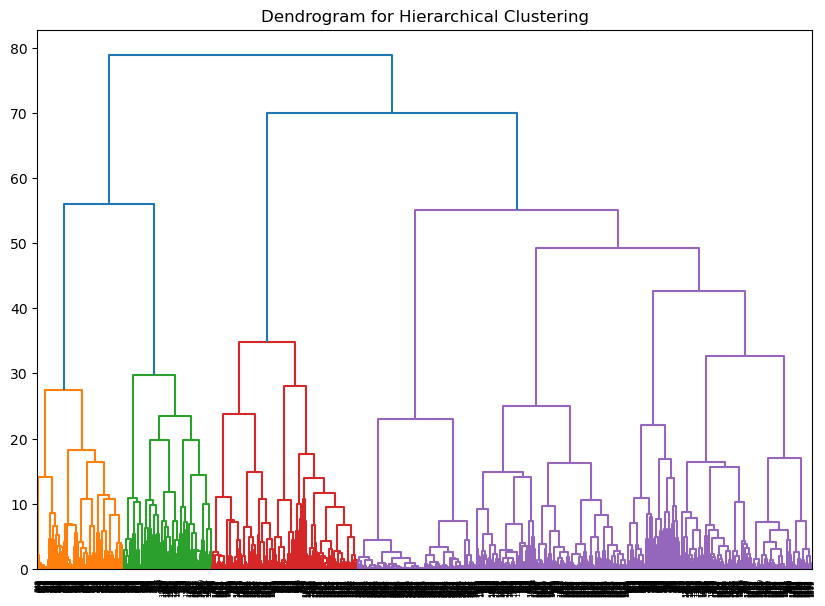

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering and plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram for Hierarchical Clustering")

# Use the 'ward' method for linkage (can be 'single', 'complete', 'average', 'ward')
Z = linkage(data_scaled, method='ward')

# Plot the dendrogram
dendrogram(Z)
plt.show()
